In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5,6,8,9'

In [2]:
from src.ModelTransfuser import ModelTransfuser

import numpy as np
import torch
from scipy.stats import norm
import os

import seaborn as sns
import matplotlib.pyplot as plt

# Load Data

In [3]:
def load_data(data_model):
    # -------------------------------------
    # Load data

    # --- Load in training data ---
    path_training = os.getcwd() + f'/data/Chempy_model_comp_data/chempy_{data_model}.npz'
    training_data = np.load(path_training, mmap_mode='r')

    elements = training_data['elements']
    train_x = training_data['params']
    train_y = training_data['abundances']

    # ---  Load in the validation data ---
    path_test = os.getcwd() + f'/data/Chempy_model_comp_data/chempy_{data_model}_val.npz'
    val_data = np.load(path_test, mmap_mode='r')

    val_x = val_data['params']
    val_y = val_data['abundances']

    # --- Clean the data ---
    # Chempy sometimes returns zeros or infinite values, which need to removed
    def clean_data(x, y):
        # Remove all zeros from the training data
        index = np.where((y == 0).all(axis=1))[0]
        x = np.delete(x, index, axis=0)
        y = np.delete(y, index, axis=0)

        # Remove all infinite values from the training data
        index = np.where(np.isfinite(y).all(axis=1))[0]
        x = x[index]
        y = y[index]

        # Remove H from Elements
        y = np.delete(y, 2, 1)

        return x, y

    train_x, train_y = clean_data(train_x, train_y)
    val_x, val_y     = clean_data(val_x, val_y)

    # convert to torch tensors
    train_x = torch.tensor(train_x, dtype=torch.float32)
    train_y = torch.tensor(train_y, dtype=torch.float32)
    val_x = torch.tensor(val_x, dtype=torch.float32)
    val_y = torch.tensor(val_y, dtype=torch.float32)

    # --- add noise ---
    pc_ab = 5 # percentage error in abundance

    train_y_err = torch.ones_like(train_y)*float(pc_ab)/100.
    train_y = norm.rvs(loc=train_y,scale=train_y_err)
    train_y = torch.tensor(train_y).float()

    val_y_err = torch.ones_like(val_y)*float(pc_ab)/100.
    val_y = norm.rvs(loc=val_y,scale=val_y_err)
    val_y = torch.tensor(val_y).float()

    # --- Concatenate the data ---
    train_data = torch.cat((train_x, train_y), 1)
    val_data = torch.cat((val_x, val_y), 1)

    return train_data, val_data

In [4]:
train_data_442, val_data_442 = load_data('442')
train_data_742, val_data_742 = load_data('742')
train_data_842, val_data_842 = load_data('842')

# Initialize ModelTransfuser

In [5]:
MTf = ModelTransfuser()

# Add Data to ModelTransfuser

In [6]:
MTf.add_data(model_name='Chempy_442', train_data=train_data_442, val_data=val_data_442)
MTf.add_data(model_name='Chempy_742', train_data=train_data_742, val_data=val_data_742)
MTf.add_data(model_name='Chempy_842', train_data=train_data_842, val_data=val_data_842)

Data added to model Chempy_442
Data added to model Chempy_742
Data added to model Chempy_842


# Initialize the SBI Models

In [7]:
MTf.init_models(sde_type="vesde", sigma=2.5, hidden_size=36, depth=5, num_heads=1, mlp_ratio=3)

Models initialized: ['Chempy_442', 'Chempy_742', 'Chempy_842']


# Train the SBI Models

In [8]:
MTf.train_models(path="data/MTf_model_comp", batch_size=512, device="cuda")

Model Chempy_442 trained
Model Chempy_742 trained
Model Chempy_842 trained


# Compare the Models on Observations

In [9]:
posterior_mask = torch.zeros_like(val_data_842[0])
posterior_mask[6:] = 1

observations = val_data_842[:1000, posterior_mask.type(torch.bool)]

In [10]:
MTf.compare(observations=observations, condition_mask=posterior_mask, timesteps=10, final_corrector_steps=3)

Probabilities of the models after 1000 observations:
Chempy_442:   0.00 %
Chempy_742:   0.00 %
Chempy_842: 100.00 %

Model Chempy_842 fits the data best with a relative support of 100.0% among the considered models and could reject the null hypothesis decisively.


# Plot Results

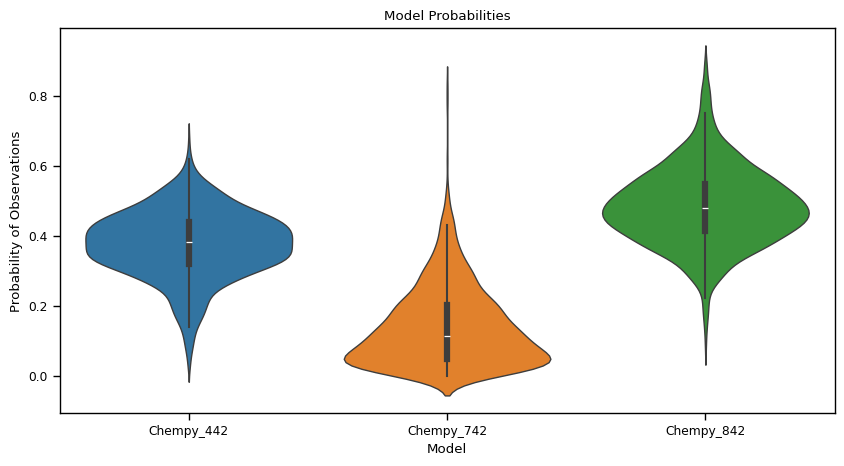

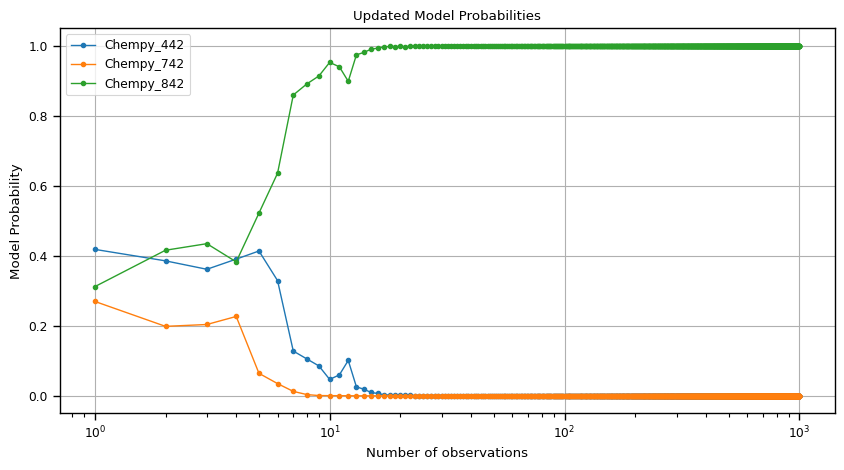

In [11]:
MTf.plots()